# Visualization of the Titanic data to look for obvious features of import

## Some basic setup first

In [143]:
# Imprts
import matplotlib.pyplot as plt



In [167]:
# Pandas for constructing dataframes and plotting 
import pandas as pd
from pandas import Series, DataFrame

# math and plotting/stats tools
import numpy as np

import seaborn as sns


# Enable in-line plots and set the style for seaborn plots
%matplotlib inline
sns.set_style("whitegrid")

# Machine Learning Packages
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

# Read in training and testing data into DataFrames
test_df = pd.read_csv("data/test.csv")
train_df = pd.read_csv("data/train.csv")

In [168]:
train_df.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",male,NaN,NaN,NaN,1601,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


This describe of the data is powerful.
* Note the count column -- we get a great idea of how complete each column is here.  
      -Age: While most columns have 891 entries, Age only has 714. We clearly need to fill in this missing data in order to do some of our tests (like random forest). 
* The unique column is also interesting to see where there are items that can only be certain values (such as Embarked, Sex)
 

In [169]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


Note that the cabin also may have some interesting agregate information when we consider only the letter (assuming the room isn't telling as there are so many of them).  We may want to strip the cabin class out when doing analysis.

### Lets clean the Age

We'll replace any missing data in the Age column with the mean over the full dataset.

**NOTE**: Looking at the distribution of ages before and after this clean step, it's clearly *NOT* the thing to do. You end up with a massive spike near the mean (not median nor mode) of the distribution.  Instead I've opted to follow a proceedure that maps the overall distribution into the cleaned data. 

In [170]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We're going to go ahead and drop a few items because they likely have no correlation (they are random variables for each entry).

In [171]:
train_df = train_df.drop(['PassengerId', 'Name','Ticket'], axis=1)

## Visualization

### Embarkation

Let's take a look at what the statistics look like for where people Embarked. Note that Embarked is described (in the online documentation) to only have three possible values, Q, S, C. Also note that there are only 2 entries where Embarked isn't one of these three values.  Lets look at this.  Since there are only 2, let's go ahead and replace these with the most occuring value of Embark

In [172]:
train_df[train_df["Embarked"].isnull() == True]
max = 0
maxval = None

unique_embarks = train_df["Embarked"][train_df["Embarked"].isnull() == False].unique()
for val in unique_embarks:
    nsubset = len(train_df[train_df["Embarked"] == "S"])
    if nsubset > max:
        max = nsubset
        maxval = val
maxval

'S'

So we will replace those missing values with 'S'

In [173]:
train_df["Embarked"] = train_df["Embarked"].fillna("S")

Make some plots with SNS

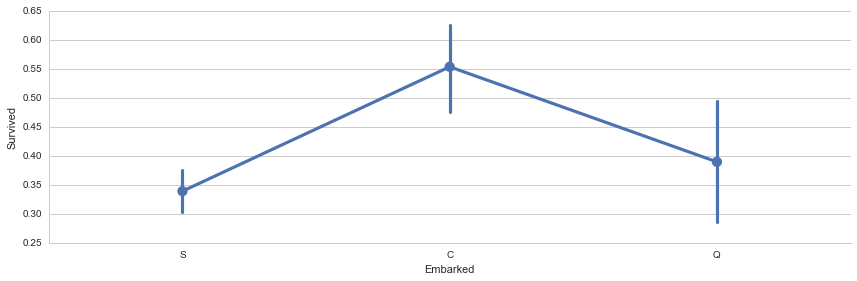

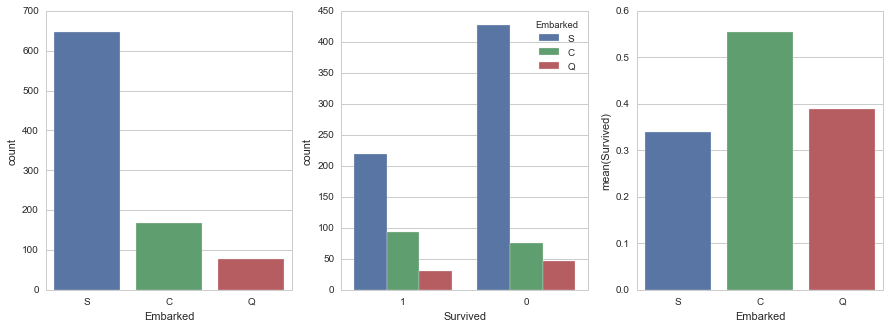

In [174]:
sns.factorplot(x="Embarked", y="Survived", data=train_df, size=4, aspect=3)

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
sns.countplot(x='Embarked', data=train_df, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=train_df, order=[1,0], ax=axis2)

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = train_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)


A factor plot is a way to plot categorical plots in seaborn.  Here, it plots the mean "Survived" value (so N_alive/N_bin is the fraction that lived) for each of the three Embarked values. It sure looks like where someone got on could play a role in if they lived  -- the people that boarded in Cherbourg (C) survived at a several-sigma higher rate than Southampton (S qith Queenstown (Q) being somehwhere between the two. 

### Fare

How do the fare paid by people that lived and people that didn't compare?

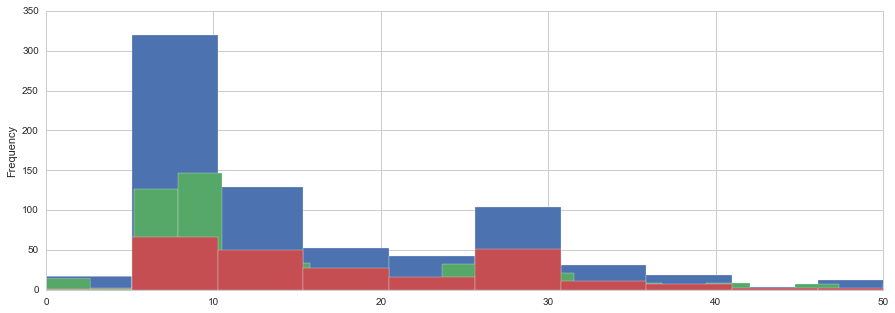

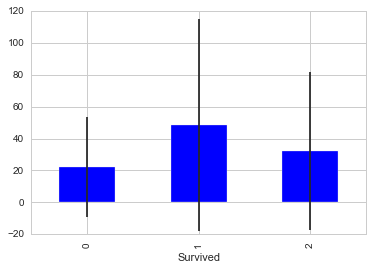

In [175]:
# Looking at Fares

# Fill any missing fares with the median
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

fare_dead = train_df["Fare"][train_df["Survived"] == 0]
fare_alive = train_df["Fare"][train_df["Survived"] == 1]
fare_all = train_df["Fare"]

# Create a DataFrame with the mean and standard deviation
avgFare = DataFrame([fare_dead.mean(), fare_alive.mean(), fare_all.mean()])
stdFare = DataFrame([fare_dead.std(), fare_alive.std(), fare_all.std()])

# Plot the histograms
fare_all.plot(kind="hist", figsize=(15, 5), bins=100, xlim=(0, 50))
fare_dead.plot(kind="hist", bins=100, xlim=(0, 50))
fare_alive.plot(kind="hist", bins=100, xlim=(0, 50))

avgFare.index.names = stdFare.index.names = ["Survived"]
avgFare.plot(yerr=stdFare, kind='bar', legend=False)

In this plot survived = 2 is the full data set.  Clearly the means of the distributions are different. Note also that the Std of the survivors is **much** higher than for the full data set and the dead passengers. This, at first glance, suggests that the high-end tail of the distribution is populated by living passengers (i.e. the more you paid, the higher the likelihood you survived).

In [176]:
train_sorted = train_df.sort_values("Fare")

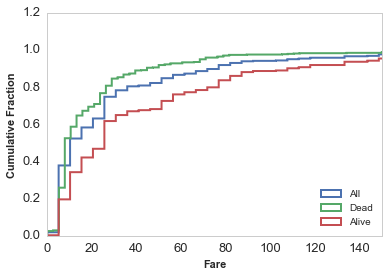

In [177]:
vals_alive = train_sorted["Fare"][train_sorted["Survived"]==1].values
vals_dead = train_sorted["Fare"][train_sorted["Survived"]==0].values
vals_all = train_sorted["Fare"].values

plt.xlim(0, 150)
plt.tick_params(axis='both', labelsize=13)
plt.xlabel("Fare",fontweight="bold")
plt.ylabel("Cumulative Fraction", fontweight="bold")
n, b, p = plt.hist(vals_all, 100, normed=1, histtype='step', cumulative=True, linewidth=2)
n, b, p = plt.hist(vals_dead, 100, normed=1, histtype='step', cumulative=True, linewidth=2)
n, b, p = plt.hist(vals_alive, 100, normed=1, histtype='step', cumulative=True, linewidth=2)
plt.legend(["All","Dead","Alive"], loc=4)
plt.grid(False)



Clearly the distributions of the Fares for each group are different.  A larger fraction of the "ALIVE" group paid more for their tickets.

### Now, let's look at Age

I mentioned before that my cleaning approach wasn't ideal.  I'm not sure this one is either, but I'm following what Relgabry did in his notebook to see what happens.

**Todo:** Try the following analysis with Age(NaN) = age.mean and see how that affects results

/Users/rcool/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rcool/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training Set Average 29.6991176471
Test set average 30.2725903614


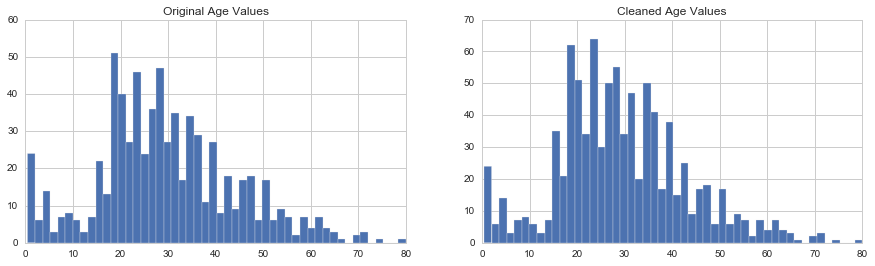

In [178]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))
axis1.set_title("Original Age Values")
axis2.set_title('Cleaned Age Values')

# Plot the original Age Values
train_df["Age"].hist(bins=50, ax=axis1)

avgAge = train_df["Age"].mean()
stdAge = train_df["Age"].std()
count_nan_age = train_df["Age"].isnull().sum()
count_nan_test = test_df["Age"].isnull().sum()

print("Training Set Average %s" % avgAge)
print("Test set average %s" % test_df["Age"].mean())

train_df["Age"]

#Rather than set the age to the mean, we set the age to a random number (uniform) between age+/-std. 
randAge = np.random.randint(avgAge-stdAge, avgAge+stdAge, size=count_nan_age)
train_df["Age"][np.isnan(train_df["Age"])] = randAge

#While we're here, we should clean the test data, because we will need an Age there
test_randAge = np.random.randint(avgAge-stdAge, avgAge+stdAge, size=count_nan_test)
test_df["Age"][np.isnan(test_df["Age"])] = test_randAge

# Plot the new distribution
train_df["Age"].hist(bins=50, ax=axis2)

Note that I use the larger training set to fill in the missing Ages in the test set. This is because they share a similar mean, so it's not a poor assumption that the testing data is drawn from the same distribution that the training data explores.


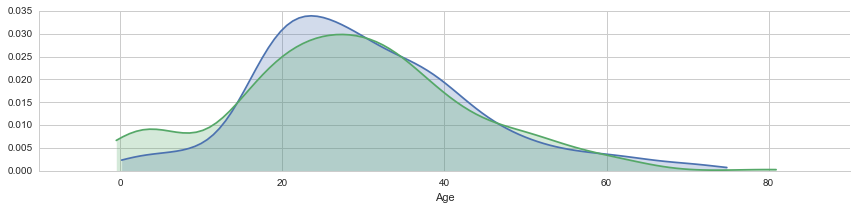

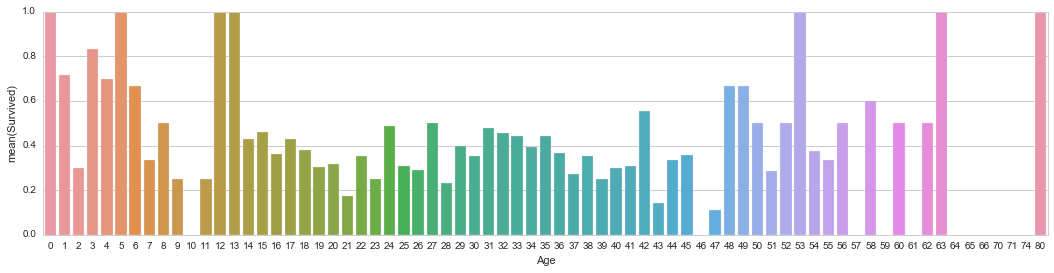

In [179]:
# Facet plot to look at the fraction of survivors as a function of Age
facet = sns.FacetGrid(train_df, hue="Survived", aspect=4) # Divide the set based on Survived value
facet.map(sns.kdeplot, "Age", shade=True) # kde - kernel distribution plot (smoothed histogram)

# Ages colored by Survival Rate
train_df['Age'] = train_df['Age'].astype(int)

# Note that this plot didn't do too well if we didn't convert the ages to ints. 
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = train_df[["Age","Survived"]].groupby(["Age"], as_index=False).mean()
sns.barplot(x="Age", y="Survived", data=average_age) 



Statistics by eye suggest Age is an important factor on if you suvived.  Children and the elderly had much higher survival rates.

## How did family and sex affect survival rates?

/Users/rcool/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/rcool/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


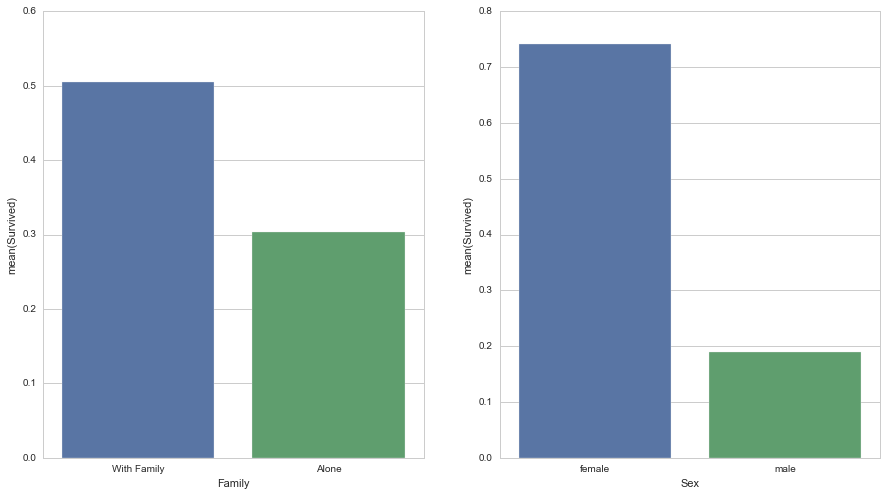

In [180]:
train_df["Family"] = train_df["Parch"] + train_df["SibSp"]
train_df["Family"][train_df["Family"] > 0] = 1

test_df["Family"] = test_df["Parch"] + test_df["SibSp"]
test_df["Family"][test_df["Family"] > 0] = 1


#Make plots
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 8))

family_percent = train_df[["Family","Survived"]].groupby(["Family"], as_index=False).mean()
sns.barplot(x="Family", y="Survived", data=family_percent, order=[1, 0], ax=axis1)
axis1.set_xticklabels(["With Family", "Alone"], rotation=0)

sex_percent = train_df[["Sex", "Survived"]].groupby(["Sex"], as_index=False).mean()
sns.barplot(x="Sex", y="Survived", data=sex_percent, ax=axis2)

So people with a family and women were much more likely to survive.

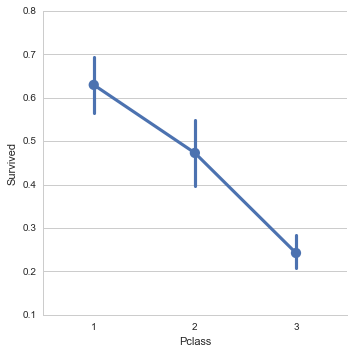

In [181]:
#Pclass
sns.factorplot("Pclass", "Survived", data=train_df, size=5)

It looks like the Pclass (passenger class -- 1 is first class) also plays an important role.  This is also probably reflected in the fare trends (they are likely highly correlated)

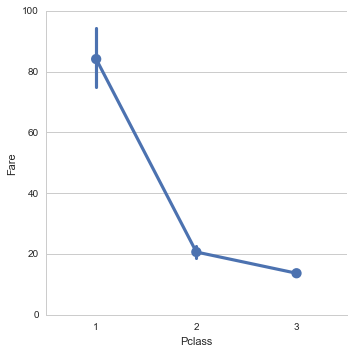

In [182]:
sns.factorplot("Pclass", "Fare", data=train_df, size=5)

So it's not clear which dominates, but I would guess (without proof) that the class matters most and the fare dependence is due to the class

In [183]:
# I'm going to create a function to make the cabin entry into something useful
def clean_cabin(x):
    try:
        return x[0]
    except TypeError:
        return "None"
train_df["Cabin"] = train_df.Cabin.apply(clean_cabin)
test_df["Cabin"] = test_df.Cabin.apply(clean_cabin)

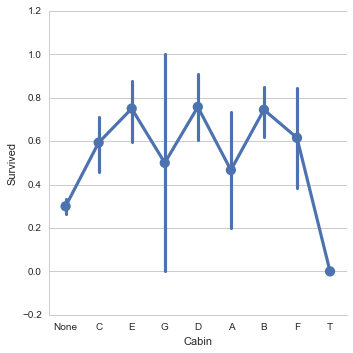

In [184]:
# Now lets do one last plot of Cabin
sns.factorplot("Cabin", "Survived", data=train_df, size=5)

So some cabins clearly had lower rates than others. We'll keep this in our analysis.

# Now, let's work on a random forest.

In [205]:
# Lets separate out features from classifiable
X = train_df.copy()
X = X.drop(['Parch', 'SibSp'], axis=1)
y = X.pop("Survived")


numeric_variables = list(X.dtypes[X.dtypes != "object"].index)


# For now, I'm leaving n_estimators = 100 
# oob_state -- lets us look at the out of bag estimator
model = RandomForestRegressor(n_estimators=100, oob_score=True)
model.fit(X[numeric_variables], y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [206]:
# For regression, the oob_score_ attribute gives the R^2 based on the oob predictions. We want to use c-stat, so we 
# calculate that as well

In [207]:
model.oob_score_

0.014951538185733471

In [208]:
# Calcualte c-stat
y_oob = model.oob_prediction_
print("c-stat: %s" % roc_auc_score(y, y_oob))

c-stat: 0.700864943172


In [209]:
# Now, let's see what to do about categorical variables
def describe_categorical(X):
    """
    Just like the .describe() but returns the results for categorical
    """
    
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == "object"]].describe().to_html()))
    

In [210]:
describe_categorical(X)

,Sex,Cabin,Embarked
count,891,891,891
unique,2,9,3
top,male,None,S
freq,577,687,646


In [211]:
# These are the only variables I have, but this is here just in case we only were doing a subset
categorical_variables = ["Sex", "Cabin", "Embarked"]

In [212]:
# A clean up function for categorical variables. Basically this makes each of the options for these variables their
# own feature. So Sex becomes Sex_male and Sex_male, eg
for variable in categorical_variables:
    
    # Fill Missing data with Missing
    X[variable].fillna("Missing", inplace=True)
    #Create array of dummies
    dummies = pd.get_dummies(X[variable], prefix=variable)
    # Update X to include dummies and drop the main variable
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)
    

In [213]:
# Look at all the columns in the dataset
def printall(X, max_rows=10):
    from IPython.display import display, HTML
    display(HTML(X.to_html(max_rows=max_rows)))

printall(X)

,Pclass,Age,Fare,Family,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,3,22,7.2500,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1
1,1,38,71.2833,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0
2,3,26,7.9250,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
3,1,35,53.1000,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1
4,3,35,8.0500,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27,13.0000,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
887,1,19,30.0000,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
888,3,30,23.4500,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1
889,1,26,30.0000,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0


In [215]:
model = RandomForestRegressor(100, oob_score=True, n_jobs=-1)
model.fit(X, y)
print("c-stat : %s" % roc_auc_score(y, model.oob_prediction_))

c-stat : 0.860647748698


# Now, lets do some exploratatory hacking of the model. 

Which features are important, which settings should I use for the random forest

In [216]:
# The importance of features are listed in this array, though it's not super helpful to read
model.feature_importances_

array([  9.31230103e-02,   2.56142486e-01,   2.42913226e-01,
         1.70676188e-02,   1.43597301e-01,   1.56480297e-01,
         3.18831682e-03,   4.34584084e-03,   6.51483941e-03,
         4.75808859e-03,   7.02548673e-03,   1.14974556e-03,
         1.05457924e-03,   2.97171693e-02,   1.02624120e-04,
         9.70383558e-03,   7.67975590e-03,   1.54357793e-02])

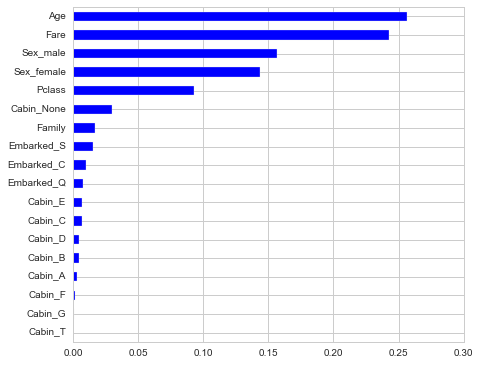

In [232]:
# Let's look at it in a more reasonable way
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort_values(inplace=True, ascending=True)
feature_importances.plot(kind="barh", figsize=(7,6))

In [233]:
feature_importances.tail()

Pclass        0.093123
Sex_female    0.143597
Sex_male      0.156480
Fare          0.242913
Age           0.256142
dtype: float64

### Important Note:

This includes the subfeatures instead of the total contribution of a given feature.

In [ ]:
def graph_feature_importances(model, feature_names, autoscale=true, headroom=0.05, width=10)